### initialize & load results

In [212]:
import sys, os, glob, datetime, cftime,pickle,collections
import xarray as xr
import numpy as np
import pandas as pd
from scipy import float64
from dill.source import getsource
import regionmask
import dask

sys.path.append('../')

from _print_and_plot import *
from linear_regression import get_slope_and_pval

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
target_variable='TREFHT'
months=[6,7,8]
months_str = ','.join([str(m) for m in months])
tag = f"{target_variable}_{'m'.join([str(m) for m in months])}"
runs = [1300,1400,1500]
periods = ['1979-2023', '2025-2075']

In [102]:
trend_dict = {period:{run:{} for run in runs} for period in periods}

### freely running raw

In [103]:
def get_histssp370_files(var, run):
    fls = []
    if int(y1) < 2015 and int(y2) >= 2015:
        compsets = ['b.e212.BHISTcmip6.f09_g17','b.e212.BSSP370cmip6.f09_g17']
    elif int(y1) >= 2015:
        compsets = ['b.e212.BSSP370cmip6.f09_g17']

    for compset in compsets:
        fl = f"/climca/data/CESM2-ETH/{compset}.{run}/{var}_day_{compset}.{run}.nc"
        if os.path.isfile(fl):
            fls += [fl]
    return fls

for period in periods:
    y1,y2 = period.split('-')
    for run in runs:
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            with xr.open_mfdataset(get_histssp370_files('TREFHT', run)) as nc:
                nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
                nc = nc.assign_coords(year=nc.time.dt.year)
                nc = nc.assign_coords(lat=nc.lat.round(3))
                tas = nc['TREFHT'].roll(lon=144, roll_coords=True)
                tas = tas.sel(time=tas['time.year'].isin(np.arange(int(y1), int(y2)+1, 1)))
                tas = tas.sel(time=tas['time.month'].isin(months))
                tas = tas.sel(lat=slice(30,70))
                tas = tas.swap_dims({'time': 'year'})
                tas = tas.groupby('year').mean().load()
                slope, p_value = get_slope_and_pval(tas)
                trend_dict[period][run]['ssp370'] = (slope * 10, p_value)

### piControl-nudged

In [108]:
for period in periods:
    y1,y2 = period.split('-')
    for run in runs:
        in_file = f"/climca/data/CESM2-ETH/b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.{run}.linear-weak/TREFHT_mon_b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.{run}.linear-weak.nc"
        with xr.open_dataset(in_file) as nc:
            nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
            nc = nc.assign_coords(year=nc.time.dt.year)
            nc = nc.assign_coords(lat=nc.lat.round(3))
            nc = nc.swap_dims({'time': 'year'})
            tas = nc['TREFHT'].loc[y1:y2].roll(lon=144, roll_coords=True)
            tas = tas[np.isin(tas.time.dt.month,months)].loc[:,30:70]
            tas = tas.groupby('year').mean().load()
            slope, p_value = get_slope_and_pval(tas)
            trend_dict[period][run]['piC-nudged'] = (slope * 10, p_value)

### ridge

In [218]:
train_test_dict = {1300:1400,1400:1500,1500:1300}
out_path = '/climca/people/ppfleiderer/decomposition/ridge_out'
for period in periods:
    y1,y2 = period.split('-')
    for run_train,run_test in train_test_dict.items():
        tab = pd.read_csv(f'{out_path}/{tag}_stream_vX_alpha1_{run_train}_{period}/train{run_train}_test{run_test}_predict_circ.csv', index_col=0).sort_index().drop_duplicates()
        lat = np.unique(tab.lat.values)
        lon = np.unique(tab.lon.values)
        tas = xr.DataArray(
                tab.iloc[:,3:].values.reshape((len(lat),len(lon),-1)),
                dims=['lat','lon','time'],
                coords=dict(
                    lat=lat, 
                    lon=lon, 
                    time=[datetime.datetime(int(t.split('/')[2]),int(t.split('/')[0]),int(t.split('/')[1])) for t in tab.columns[3:]]
                    )
            )
        tas = tas.transpose('time','lat','lon')

        tas = tas.assign_coords(lon=(tas.lon + 180) % 360 - 180)
        tas = tas.assign_coords(year=tas.time.dt.year)
        tas = tas.assign_coords(lat=tas.lat.round(3))
        tas = tas.swap_dims({'time': 'year'})
        tas = tas.loc[y1:y2].roll(lon=144, roll_coords=True)
        tas = tas[np.isin(tas.time.dt.month,months)].loc[:,30:70]
        tas = tas.groupby('year').mean().load()
        slope, p_value = get_slope_and_pval(tas)
        trend_dict[period][run_test][f'ridge'] = (slope * 10, p_value)

### analogues

In [110]:
train_test_dict = {1300:1400,1400:1500,1500:1300}
data_path = '/climca/data/ETH2LIM/ETH2LIM/for_sebastian/'
for period in periods:
    y1,y2 = period.split('-')
    for run_train,run_test in train_test_dict.items():
        analog_in_file = f"{data_path}/tasAdj_mon_{run_train}_analogues_{run_test}_target_NH_mask.nc"
        nc = xr.open_dataset(analog_in_file)
        nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
        tas = nc['tas_dyn'].roll(lon=144, roll_coords=True)
        tas = tas[np.isin(tas.time.dt.month, months)]
        tas = tas.loc[y1:y2]
        tas = tas.groupby(tas.time.dt.year).mean()
        slope__, p_value__ = get_slope_and_pval(tas)
        slope = trend_dict[period][run]['piC-nudged'][0].copy() * np.nan
        slope[:] = slope__.sel(dict(lat=slope.lat, lon=slope.lon), method='nearest').values
        p_value = trend_dict[period][run]['piC-nudged'][0].copy() * np.nan
        p_value[:] = p_value__.sel(dict(lat=p_value.lat, lon=p_value.lon), method='nearest').values
        trend_dict[period][run_test][f'analog'] = (slope * 10, p_value)

### DEA

In [165]:
for period in periods:
    for run_train,run_test in train_test_dict.items():
        nc = xr.load_dataset(f'/climca/people/ppfleiderer/decomposition/DEA_homer/train{run_train}_test{run_test}_trend_{period}_dyn.nc')
        nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
        nc = nc.roll(lon=144, roll_coords=True)
        slope__,p_value__ = nc['slope'], nc['pval']
        slope = trend_dict[period][run]['piC-nudged'][0].copy() * np.nan
        slope[:] = slope__.sel(dict(lat=slope.lat, lon=slope.lon), method='nearest').values
        p_value = trend_dict[period][run]['piC-nudged'][0].copy() * np.nan
        p_value[:] = p_value__.sel(dict(lat=p_value.lat, lon=p_value.lon), method='nearest').values
        trend_dict[period][run_test][f'DEA'] = (slope * 10, p_value)

### UNET

In [104]:
for period in periods:
    y1,y2 = period.split('-')
    for run in runs:
        in_file = f'/climca/data/ETH2LIM/CNRM2LIM/UNET/UNET_day_b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.{run}.nc'
        with xr.open_dataset(in_file) as nc:
            nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
            nc = nc.assign_coords(year=nc.time.dt.year)
            nc = nc.assign_coords(lat=nc.lat.round(3))
            nc = nc.swap_dims({'time': 'year'})
            tas = nc['tas'].loc[y1:y2]
            tas = tas[np.isin(tas.time.dt.month,months)].loc[:,30:70]
            tas = tas.groupby('year').mean().load()
            slope, p_value = get_slope_and_pval(tas)
            trend_dict[period][run]['UNET'] = (slope * 10, p_value)
    

### mask oceans

In [219]:
for period in periods:
    for run,d in trend_dict[period].items():
        for k,v in d.items():
            mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(v[0].lon, v[0].lat)
            mask.values[np.isfinite(mask)] = 1
            slope = v[0] * mask
            p_value = v[1] * mask
            trend_dict[period][run][k] = (slope, p_value)

## plot maps

In [220]:
maxabs = 0.4
levels = np.linspace(-maxabs,maxabs,17)
extent = [-180, 180, 30, 60]

colors = plt.cm.RdBu(np.linspace(0., 1, 19))[::-1]
for i in range(7,12):
    colors[i] = (0.8,0.8,0.8,1)
cmap_ = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', colors, len(colors))

### piControl nudged

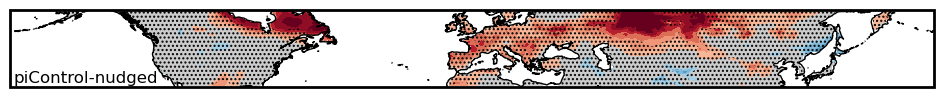

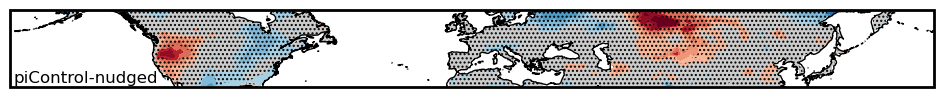

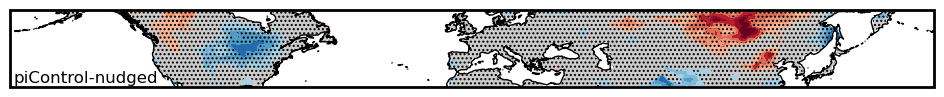

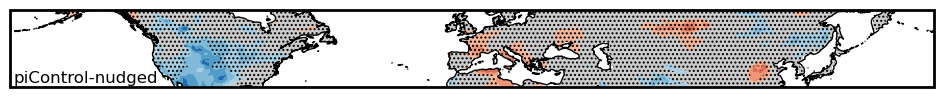

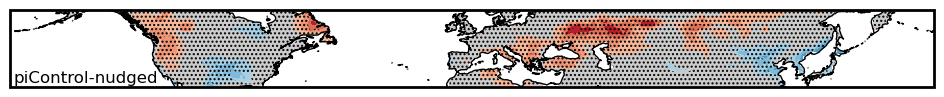

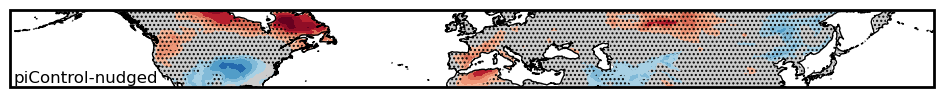

In [221]:
plt.close('all')
name = 'piC-nudged'
for period in periods:
    for run,d in trend_dict[period].items():
        fig,ax = plt.subplots(nrows=1, figsize=(12,1), subplot_kw={'projection': cartopy.crs.PlateCarree()})
        ax.coastlines()
        ax.set_extent(extent, crs=cartopy.crs.PlateCarree())
        xxx = d[name][0]
        im = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), cmap=cmap_, levels=levels, extend='both')
        xxx = d[name][1]
        im2 = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), colors='none', hatches=['','....'], levels=[0,0.05,1])
        ax.annotate('piControl-nudged', xy=(0.004,0.05), xycoords='axes fraction', fontsize=12)
        ax.spines['geo'].set_linewidth(2)
        savefig(f"trend_maps_{period}_{run}_{name}_sign") 

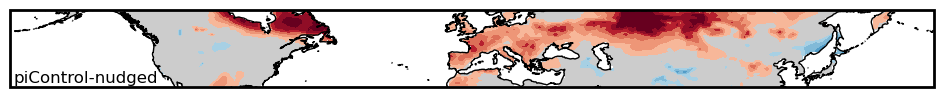

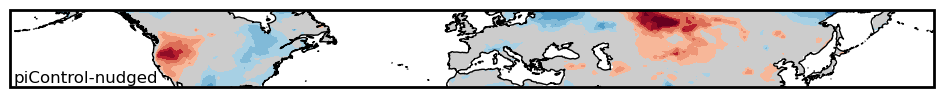

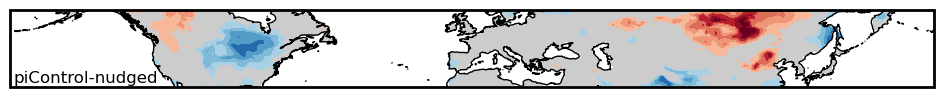

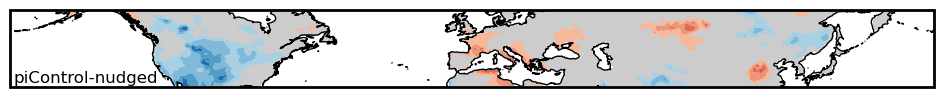

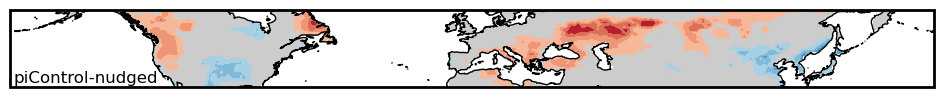

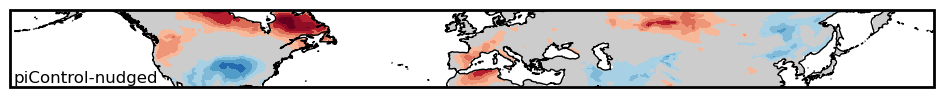

In [222]:
plt.close('all')
name = 'piC-nudged'
for period in periods:
    for run,d in trend_dict[period].items():
        fig,ax = plt.subplots(nrows=1, figsize=(12,1), subplot_kw={'projection': cartopy.crs.PlateCarree()})
        ax.coastlines()
        ax.set_extent(extent, crs=cartopy.crs.PlateCarree())
        xxx = d[name][0]
        im = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), cmap=cmap_, levels=levels, extend='both')
        ax.annotate('piControl-nudged', xy=(0.004,0.05), xycoords='axes fraction', fontsize=12)
        ax.spines['geo'].set_linewidth(2)
        savefig(f"trend_maps_{period}_{run}_{name}_neutral") 

### color bar

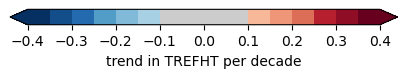

In [223]:
fig,ax = plt.subplots(figsize=(5, 0.2))
plt.colorbar(im, cax=ax, orientation='horizontal', label=f'trend in {target_variable} per decade')
savefig(f"trend_maps_cbar_{maxabs}")

### decomposition predictions

In [224]:
to_plot = {
    'ridge' : 'ridge',
    'analog' : 'analogues',
    'DEA' : 'DEA',
    'UNET' : 'UNET',
}

#### circ

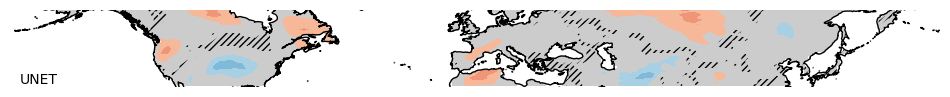

In [225]:
plt.close('all')
for period in periods:
    for run,d in trend_dict[period].items():
        for name,long_name in to_plot.items():
            plt.close('all')
            fig,ax = plt.subplots(nrows=1, figsize=(12, 2), subplot_kw={'projection': cartopy.crs.PlateCarree()})
            ax.coastlines()
            ax.set_extent(extent)
            xxx = d[name][0]
            im = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), cmap=cmap_, levels=levels, extend='both')
            xxx = (np.sign(d[name][0]) == np.sign(d['piC-nudged'][0])).astype(float)
            xxx.values[np.isnan(d[name][0])] = np.nan
            cs1 = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), levels=[-0.5, 0.5], hatches=["/////"], colors='none')
            #cs1.set_edgecolor('gray')
            #xxx = d[name][1]
            #cs2 = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), colors='none', hatches=['','...'], levels=[0,0.1,1])
            ax.annotate(long_name, xy=(0.01,0.05), xycoords='axes fraction', fontsize=10)
            ax.spines['geo'].set_visible(False)
            savefig(f"trend_maps_{period}_{run}_{name}") 


#### thermo

In [226]:
maxabs = 1
levels = np.linspace(-maxabs,maxabs,17)
extent = [-180, 180, 30, 60]

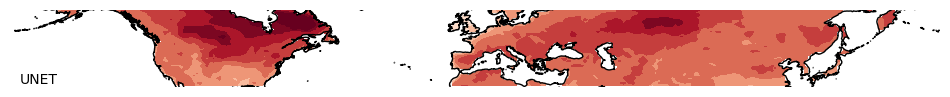

In [227]:
plt.close('all')
for period in periods:
    for run,d in trend_dict[period].items():
        for name,long_name in to_plot.items():
            plt.close()
            fig,ax = plt.subplots(nrows=1, figsize=(12, 2), subplot_kw={'projection': cartopy.crs.PlateCarree()})
            ax.coastlines()
            ax.set_extent(extent)
            xxx = (d['ssp370'][0] - d[name][0])
            im = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')

            ax.annotate(long_name, xy=(0.01,0.05), xycoords='axes fraction', fontsize=10)
            ax.spines['geo'].set_visible(False)
            savefig(f"trend_maps_{period}_{run}_{name}_thermo")             


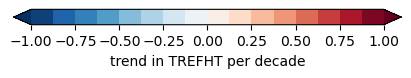

In [228]:
fig,ax = plt.subplots(figsize=(5, 0.2))
plt.colorbar(im, cax=ax, orientation='horizontal', label=f'trend in {target_variable} per decade')
savefig(f"trend_maps_cbar_{maxabs}")

## result statistics

In [229]:
def print_block(method_names, func, period):
    t = ""
    t += '\midrule \n'
    t += ' &  \multicolumn{' + str(len(method_names)) + '}{l}{' + str(func.__name__).replace('_',' ') + '} \\\\ \n'
    t += '\midrule \n'

    # all
    t += "\\textbf{"
    t += "all runs} & "
    for method_name in method_names:
        l_y = []
        l_f = []
        for run,d in trend_dict[period].items():
            y = d['piC-nudged'][0].loc[30:60].values
            f = d[method_name][0].loc[30:60].values
            land = np.isfinite(y) & np.isfinite(f)
            l_f.append(f[land])
            l_y.append(y[land])

        t += "\\textbf{"
        t += func(np.concatenate(l_y),np.concatenate(l_f))
        t += '} & '
    t = t[:-3]
    t += ' \\\\\n'

    for run,d in trend_dict[period].items():
        t += f"{int(run)} & "
        for method_name in method_names:
            y = d['piC-nudged'][0].loc[30:60].values
            f = d[method_name][0].loc[30:60].values
            land = np.isfinite(y) & np.isfinite(f)
            f = f[land]
            y = y[land]

            t += func(y,f)
            t += ' & '
        t = t[:-3]
        t += ' \\\\\n'
        

    print(t)

In [230]:
def R2(y,f):
    v = float(1 - np.sum((y - f)**2) / np.sum((y - y.mean())**2))
    if v < 0:
        return "\color{red}{" + f"{v:.2f}" + "}"
    else:
        return f"{v:.2f}"

def Pearson_correlation(y,f):
    return f"{np.corrcoef(y,f)[0,1]:.2f}"

def correct_sign(y,f):
    y = y[np.abs(f) > 0.1]
    f = f[np.abs(f) > 0.1]
    return f"{round(np.sum(np.sign(y) == np.sign(f)) / y.shape[0] * 100)}\%"

def regression_slope(y,f):
    slope=sm.OLS(f, sm.add_constant(y)).fit().params[1]
    return f"{slope:.2f}"

In [231]:
for period in periods:
    print(period)
    method_names = ['ridge', "analog", "DEA", 'UNET']
    print_block(method_names, correct_sign, period)
    print_block(method_names, Pearson_correlation, period)
    print_block(method_names, R2, period)
    print_block(method_names, regression_slope, period)


1979-2023
\midrule 
 &  \multicolumn{4}{l}{correct sign} \\ 
\midrule 
\textbf{all runs} & \textbf{94\%} & \textbf{70\%} & \textbf{84\%} & \textbf{100\%} \\
1300 & 96\% & 86\% & 78\% & 100\% \\
1400 & 90\% & 58\% & 89\% & 100\% \\
1500 & 94\% & 64\% & 85\% & 100\% \\

\midrule 
 &  \multicolumn{4}{l}{Pearson correlation} \\ 
\midrule 
\textbf{all runs} & \textbf{0.75} & \textbf{0.49} & \textbf{0.57} & \textbf{0.86} \\
1300 & 0.79 & 0.62 & 0.61 & 0.91 \\
1400 & 0.67 & 0.51 & 0.80 & 0.83 \\
1500 & 0.75 & 0.36 & 0.63 & 0.89 \\

\midrule 
 &  \multicolumn{4}{l}{R2} \\ 
\midrule 
\textbf{all runs} & \textbf{0.53} & \textbf{\color{red}{-0.12}} & \textbf{0.03} & \textbf{0.66} \\
1300 & 0.54 & 0.27 & \color{red}{-0.38} & 0.50 \\
1400 & 0.39 & \color{red}{-0.98} & 0.13 & 0.67 \\
1500 & 0.48 & \color{red}{-0.16} & 0.08 & 0.73 \\

\midrule 
 &  \multicolumn{4}{l}{regression slope} \\ 
\midrule 
\textbf{all runs} & \textbf{0.66} & \textbf{0.44} & \textbf{0.64} & \textbf{0.51} \\
1300 & 0.59 & 0.51

## trend scatters

### combined

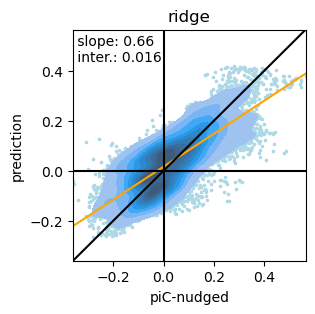

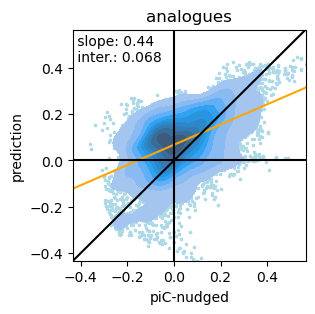

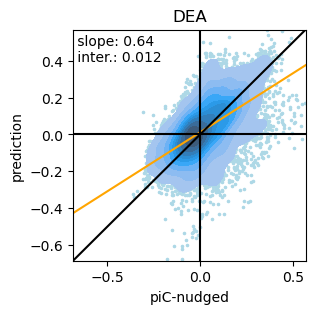

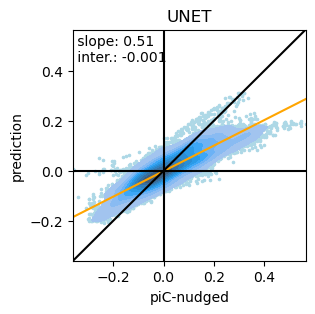

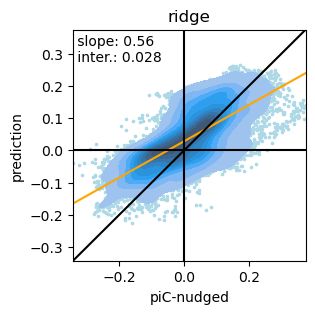

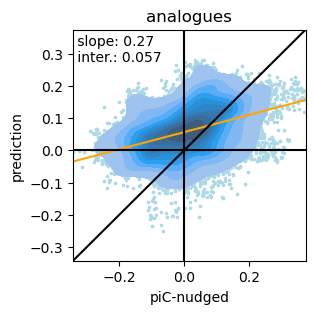

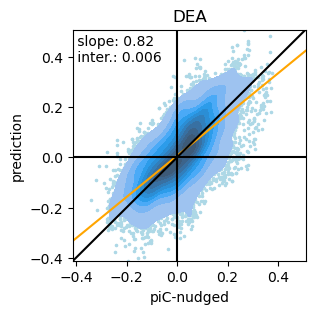

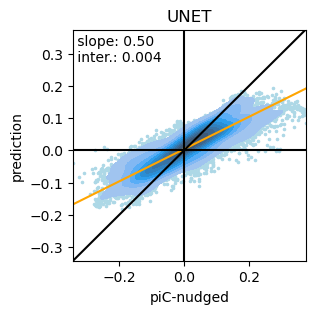

In [232]:
for period in periods:
    for name,long_name in to_plot.items():
        fig,ax = plt.subplots(figsize=(3,3))
        ax.set_title(long_name)
        l_x = []
        l_y = []
        for run,d in trend_dict[period].items():
            x = d['piC-nudged'][0].loc[30:60].values
            y = d[name][0].loc[30:60].values
            land = np.isfinite(y) & np.isfinite(x)
            l_x.append(x[land])
            l_y.append(y[land])

        x = np.concatenate(l_x)
        y = np.concatenate(l_y)
        ax.scatter(x, y, marker='.', s=10, zorder=0, color='lightblue')
        sns.kdeplot(x=x, y=y, ax=ax, fill=True, zorder=1)
        mini = np.concatenate([x,y]).min()
        maxi = np.concatenate([x,y]).max()
        intercept, slope = sm.OLS(y, sm.add_constant(x)).fit().params
        ax.plot([mini,maxi], np.array([mini,maxi]) * slope + intercept, color='orange')
        ax.annotate(f' slope: {slope:.2f}\n inter.: {intercept:.3f}', xy=(0,0.98), xycoords='axes fraction', va='top', fontsize=10)
        # \n inter.: {intercept:.2f}
        ax.set_xlim(mini,maxi)
        ax.set_ylim(mini,maxi)
        ax.plot([mini,maxi],[mini,maxi], color='k')
        ax.axhline(0, color='k')
        ax.axvline(0, color='k')
        ax.set_xlabel('piC-nudged')
        ax.set_ylabel('prediction')
        savefig(f'trend_scatter_{name}_{period}')


### individual

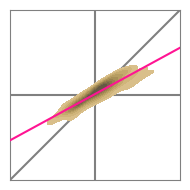

In [233]:
maxabs = 0.5
for period in periods:
    for name,long_name in to_plot.items():
        for run,d in trend_dict[period].items():
            plt.close()
            fig,ax = plt.subplots(figsize=(2,2))
            x = d['piC-nudged'][0].loc[30:60].values
            y = d[name][0].loc[30:60].values
            land = np.isfinite(y) & np.isfinite(x)
            x = x[land]
            y = y[land]
            #ax.scatter(x, y, marker='.', s=10, zorder=0, color='gray')
            sns.kdeplot(x=x, y=y, ax=ax, fill=True, zorder=10, color='wheat')
            intercept, slope = sm.OLS(y, sm.add_constant(x)).fit().params
            ax.plot([-maxabs,maxabs], np.array([-maxabs,maxabs]) * slope + intercept, color='deeppink', zorder=20)
            ax.set_xlim(-maxabs,maxabs)
            ax.set_ylim(-maxabs,maxabs)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.plot([-maxabs,maxabs],[-maxabs,maxabs], color='gray', zorder=0)
            ax.axhline(0, color='gray', zorder=0)
            ax.axvline(0, color='gray', zorder=0)
            plt.setp(ax.spines.values(), color='gray')
            #ax.set_xlabel('piC-nudged')
            #ax.set_ylabel('prediction')
            plt.tight_layout()
            savefig(f"trend_scatter_{period}_{run}_{name}")
